# Document Type Classification 2조

### Contents
- Import Library & Loading Data
- EDA
- Data Preprocessing
- Define Functions
- Modeling
- Train Model
- Result
- Save File

## 1. Import Library

In [19]:
import os
import time
import random
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam, AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import augraphy
from sklearn.model_selection import KFold
from glob import glob
from matplotlib.gridspec import GridSpec
from timm import create_model
import wandb
import torchvision.transforms as T
from collections import Counter

In [ ]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [25]:
#csv 파일 로드
train_df = pd.read_csv("/Users/choesumin/Documents/upstage/data/train.csv")
meta_df = pd.read_csv("/Users/choesumin/Documents/upstage/data/meta.csv")
image_dir = "/Users/choesumin/Documents/upstage/data/train"
test_image_dir = "/Users/choesumin/Documents/upstage/data/test"

#매핑
train_df = train_df.merge(meta_df, on='target')

In [ ]:
#EDA

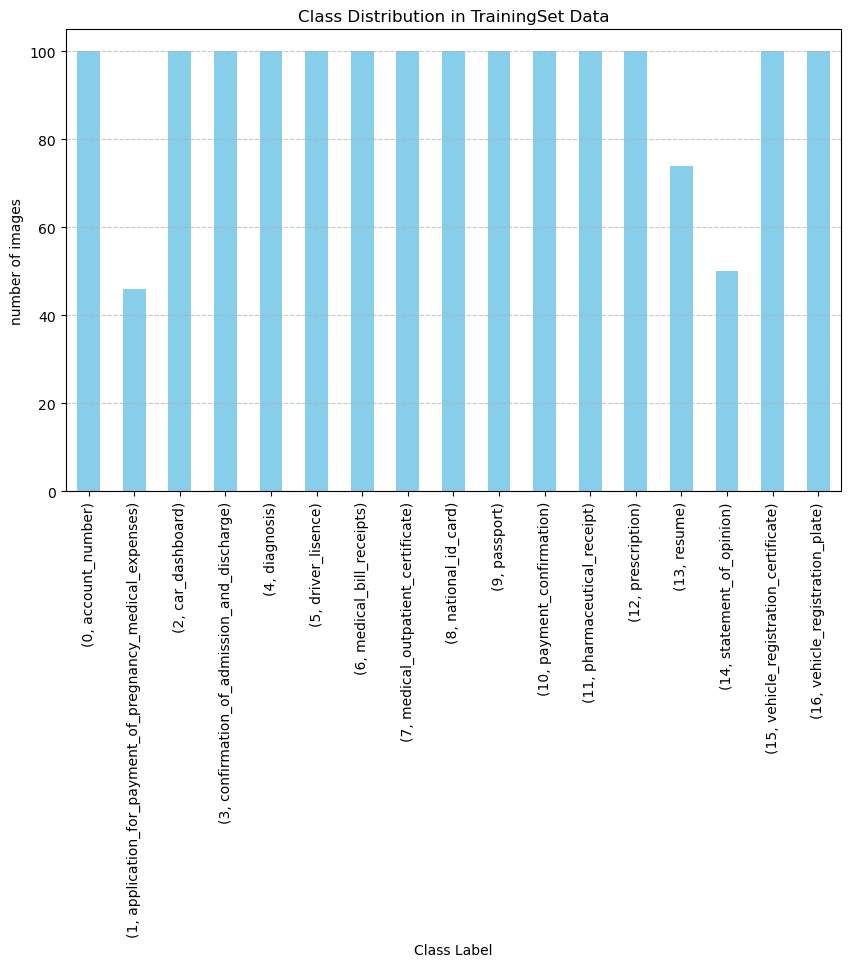

In [13]:
# 'target' 컬럼의 값에 대한 빈도수 계산
class_counts = train_df[['target','class_name']].value_counts().sort_index()

# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in TrainingSet Data')
plt.xlabel('Class Label')
plt.ylabel('number of images')
plt.xticks(rotation=90)  # 클래스 레이블이 수평으로 표시되도록 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# 이미지 크기 추출 함수
def check_image_sizes(directory):
    sizes = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(directory, filename)
            with Image.open(filepath) as img:
                sizes.append(img.size)
    return sizes

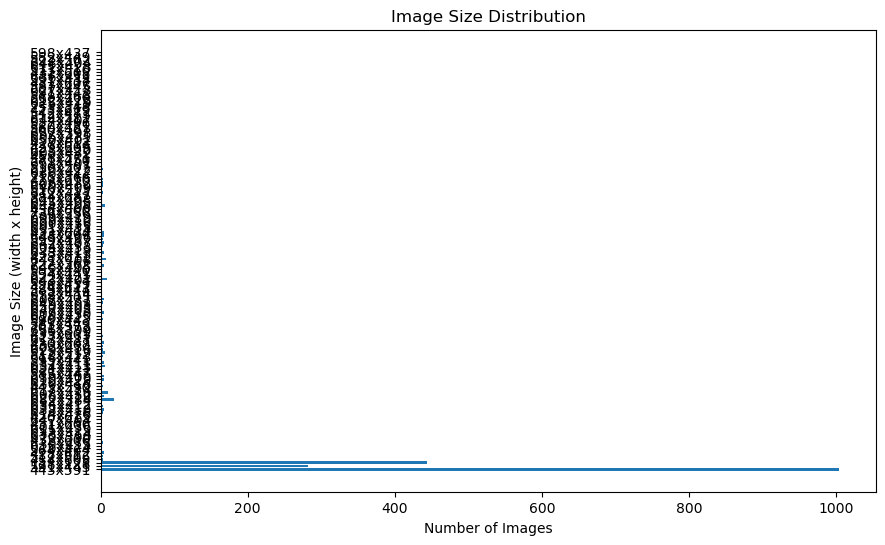

In [23]:
sizes = check_image_sizes(image_dir)
size_counts = Counter(sizes)

# 크기와 빈도 데이터 분리
sizes, counts = zip(*size_counts.items())

# 트레이닝 데이터 이미지 크기 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(counts)), counts, tick_label=[f'{w}x{h}' for w, h in sizes])
plt.xlabel('Number of Images')
plt.ylabel('Image Size (width x height)')
plt.title('Image Size Distribution')
plt.show()

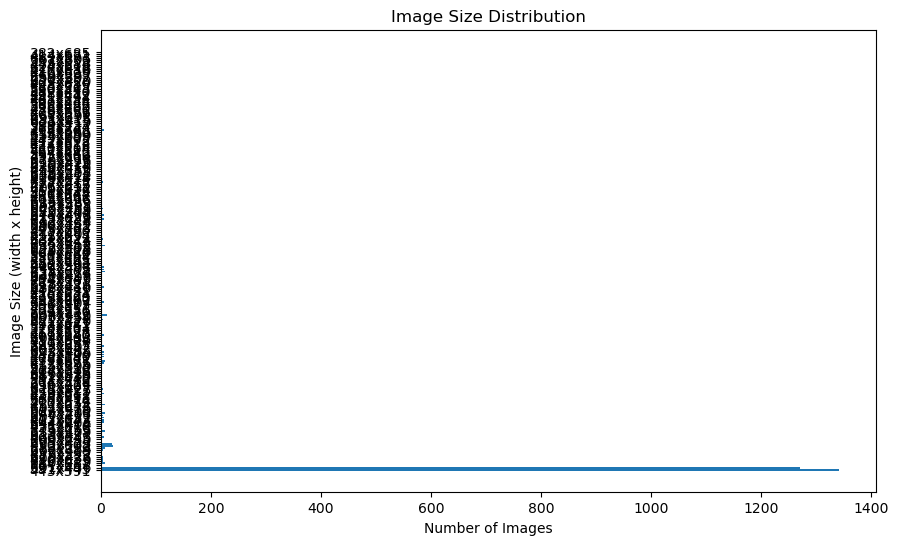

In [27]:
#테스트 데이터 이미지 크기 시각화
sizes2 = check_image_sizes(test_image_dir)
size_counts2 = Counter(sizes2)

# 크기와 빈도 데이터 분리
sizes2, counts2 = zip(*size_counts2.items())

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(counts2)), counts2, tick_label=[f'{w}x{h}' for w, h in sizes2])
plt.xlabel('Number of Images')
plt.ylabel('Image Size (width x height)')
plt.title('Image Size Distribution')
plt.show()

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#data config
data_path = image_dir

#model config
model_name = 'tf_efficientnet_b5.ns_jft_in1k'

#training config
pre_img_size = 600
img_size = 456 #224 #256
LR = 5e-4
EPOCHS = 5
BATCH_SIZE = 8
num_workers = 4
early_stopping_patience = 5  # Early Stopping 설정
augment_ratio = 200

In [ ]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [ ]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, oversample=False, augment_ratio=1):
        self.df = pd.read_csv(csv)
        self.path = path
        self.transform = transform
        self.oversample = oversample
        self.augment_ratio = augment_ratio

        # 클래스간 불균형 해소를 위한 샘플 증식
        if self.oversample:
            # 각 클래스별로 데이터 수 계산
            class_counts = np.bincount(self.df.values[:, 1].astype(int))

            # 각 클래스별로 증식할 횟수 설정 (이 예제에서는 최대 데이터 수에 맞춤)
            max_class_count = max(class_counts)
            oversample_factors = [max_class_count // count for count in class_counts] 

            # 각 클래스별로 데이터를 증식한 새로운 데이터 프레임 생성
            oversampled_data = [self.df.values[self.df.values[:, 1] == cls].repeat(factor, axis=0) for cls, factor in enumerate(oversample_factors)]
            oversampled_data = np.vstack(oversampled_data)

            self.df = pd.DataFrame(oversampled_data, columns=self.df.columns)

    def __len__(self):
        return len(self.df) * self.augment_ratio

    def __getitem__(self, idx):
        real_idx = idx % len(self.df)
        name, target = self.df.iloc[real_idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert("RGB"))
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [29]:
label_to_class_name = dict(zip(meta_df['target'], meta_df['class_name']))

## 전처리

In [ ]:
class Crop(A.ImageOnlyTransform):
    def __init__(self, crop_position='top', always_apply=False, p=1.0):
        super(Crop, self).__init__(always_apply, p)
        self.crop_position = crop_position

    def apply(self, img, **params):
        # 이미지를 PIL 이미지로 변환 (Albumentations은 NumPy 배열을 사용)
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        width, height = img.size

        if self.crop_position == 'top':
            img = img.crop((0, 0, width, height // 2))
        elif self.crop_position == 'bottom':
            img = img.crop((0, height // 2, width, height))
        else:
            raise ValueError("crop_position must be 'top' or 'bottom'")

        # PIL 이미지를 다시 NumPy 배열로 변환
        img = np.array(img)
        return img

In [ ]:
class Adjust(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super(Adjust, self).__init__(always_apply, p)

    def apply(self, img, **params):
        
        # 이미지를 PIL 이미지로 변환 (Albumentations은 NumPy 배열을 사용)
        if isinstance(img, np.ndarray):
            # img = Image.fromarray(img)
            img = Image.fromarray(img.astype(np.uint8))
        # PIL 이미지를 다시 NumPy 배열로 변환
        img = np.array(img)               
                
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        average_brightness = np.mean(gray_image)
        # print(average_brightness)
        if average_brightness < 160:
            img_pil = Image.fromarray(img)
            # Adjust brightness
            enhancer = ImageEnhance.Brightness(img_pil)
            img_pil = enhancer.enhance(1.5)
            
            # Adjust contrast
            enhancer = ImageEnhance.Contrast(img_pil)
            img_pil = enhancer.enhance(2.0)
            
            img = np.array(img_pil)
        
        return img

## Augmentation

In [35]:
# horizontal_flip, vertical_flip, double_flip, transpose 등 변환 정의
horizontal_flip = A.HorizontalFlip(p=1)
vertical_flip = A.VerticalFlip(p=1)
double_flip = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
])
transpose = A.Transpose(p=1)
transpose_hflip = A.Compose([
    A.Transpose(p=1), 
    A.HorizontalFlip(p=1),
])
transpose_vflip = A.Compose([
    A.Transpose(p=1),
    A.VerticalFlip(p=1),
])
transpose_dflip = A.Compose([
    A.Transpose(p=1),  
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
])

# Augmentation을 위한 transform 코드
trn_transform = A.Compose([
    A.LongestMaxSize(max_size=pre_img_size, always_apply=True),
    A.PadIfNeeded(min_height=pre_img_size, min_width=pre_img_size, border_mode=0, value=(255, 255, 255)),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 800.0), p=1),
        A.GaussianBlur(blur_limit=(1, 7), p=1),
        A.MotionBlur(blur_limit=(3, 7), p=1),
        A.MedianBlur(blur_limit=3, p=1)
    ], p=1),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.25),
    A.Rotate(limit=(0, 360), p=0.75),
    A.GridDistortion(always_apply=False, p=0.75, num_steps=6, distort_limit=(-0.3, 0.3), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None, normalized=False),
    A.OneOf([
        horizontal_flip,
        vertical_flip,
        double_flip,
        transpose,
        transpose_hflip,
        transpose_vflip,
        transpose_dflip
    ], p=1.0),
    A.OneOf([
        A.OpticalDistortion(always_apply=False, p=1.0, distort_limit=(-0.3, 0.3), shift_limit=(-0.05, 0.09), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
        A.MultiplicativeNoise(always_apply=False, p=1.0, multiplier=(0.93, 2.22), per_channel=True, elementwise=True),
        A.ISONoise(always_apply=False, p=1.0, intensity=(0.38, 1.0), color_shift=(0.18, 0.47)),
        A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(0.19, 0.62), contrast_limit=(-0.02, 0.62), brightness_by_max=True)
    ], p=0.75),
    
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    #Adjust(always_apply=True),
    A.LongestMaxSize(max_size=pre_img_size, always_apply=True),
    A.PadIfNeeded(min_height=pre_img_size, min_width=pre_img_size, border_mode=0, value=(255, 255, 255)),
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

NameError: name 'pre_img_size' is not defined

## Augraphy

## Mixup